In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import animation
from matplotlib import rc
rc('animation', html='html5')

from Ecosystem import Ecosystem

cmap = colors.ListedColormap(['White','Blue','Green','Red'])

# #normalizes colour range values 
n = colors.Normalize(vmin=0,vmax=3)

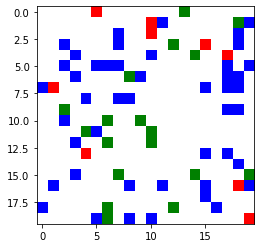

In [2]:
## Declarations
rows=20

eco = Ecosystem(rows, omni=True)

#Population of Species
numFoxes=10
numRabbits=20
numMushrooms=50

rabbit_step_size=8
fox_step_size=4

## Initialise and Spawn Foxes & Rabbits
    
# Foxes
eco.createFoxes(numFoxes, fox_step_size, maxHunger=15)
foxes = eco.foxes_array

# Rabbits
eco.createRabbits(numRabbits, rabbit_step_size, maxHunger=12)
rabbits = eco.rabbits_array

# Mushrooms
eco.createMushrooms(numMushrooms)
mushrooms = eco.mush_array

# Show the initial state of the forest
data = eco.mapToGrid()
eco.plotGrid(data)

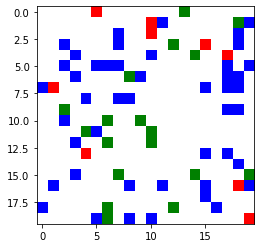

In [3]:
maxFrames = 2000
anim = eco.animate(maxFrames)

In [4]:
anim

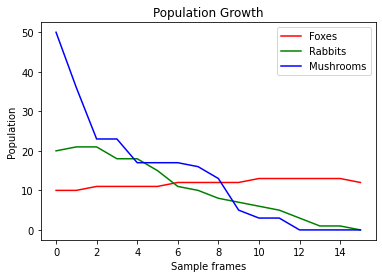

In [5]:
eco.plotPopulationHist()